In [1]:
from model import FreckerDataSet
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from model import MaskLoss, FreckersNet
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
# file = r"C:\Users\lucyc\Desktop\freckers_data\P1.h5"
# file2 = r"C:\Users\lucyc\Desktop\freckers_data\P2.h5"
# dataset1 = FreckerDataSet(file_path=file)
# dataset2 = FreckerDataSet(file_path=file2)

#dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])

file_base_path = r"C:\Users\lucyc\Desktop\data"
versions = [str(i) for i in range(1, 10)]
datasets = [FreckerDataSet(file_base_path + "\\" + v + ".h5") for v in versions]

# # 合并两个数据集
dataset = torch.utils.data.ConcatDataset(datasets)

# dataset = FreckerDataSet(file_path=file)
# dataset = torch.utils.data.Subset(dataset, range(int(len(dataset) * (9/11)), len(dataset)))


# 按照顺序分割数据集
train_size = int(0.8 * len(dataset))  # 50% 用于训练
val_size = len(dataset) - train_size  # 50% 用于验证

# 使用 Subset 分割数据集
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_dataset, _ = random_split(train_dataset, [int(0.1 * len(train_dataset)), len(train_dataset) - int(0.1 * len(train_dataset))])
val_dataset, _ = random_split(val_dataset, [int(0.1 * len(val_dataset)), len(val_dataset) - int(0.1 * len(val_dataset))])
# 随机分割
# train_dataset, val_dataset = random_split(dataset, [int(0.5 * len(dataset)), len(dataset) - int(0.5 * len(dataset))])
# print(f"合并后的数据集大小: {len(train_dataset)}")

# # 定义训练集和验证集的大小
# train_size = int(0.8 * len(dataset))  # 80% 用于训练
# val_size = len(dataset) - train_size  # 20% 用于验证

# # 使用 random_split 分割数据集
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
shuffle = True
num_workers = 1

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, persistent_workers=True)


In [8]:
model = FreckersNet()

In [9]:
num_epochs = 10
stop_epoch = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.01)
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.001,  # 最大学习率
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.2  # warmup 的比例
)
mask_loss = MaskLoss()

train_loss_record = []
eval_loss_record = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for gameboard, action_prob, value in train_loader:
        gameboard = gameboard.to(device)
        action_prob = action_prob.to(device)
        value = value.to(device)

        optimizer.zero_grad()
        p_action_prob, p_value = model(gameboard)
        # 计算双损失
        loss_img = mask_loss(p_action_prob, action_prob)
        loss_prob = F.mse_loss(p_value.view(-1), value)
        total_loss = loss_img + loss_prob
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += total_loss.item()
    
    train_loss /= len(train_loader)
    train_loss_record.append(train_loss)

    model.eval()
    eval_loss = 0.0
    with torch.no_grad():
        for gameboard, action_prob, value in val_loader:
            gameboard = gameboard.to(device)
            action_prob = action_prob.to(device)
            value = value.to(device)

            p_action_prob, p_value = model(gameboard)
            loss_img = mask_loss(p_action_prob, action_prob)
            loss_prob = F.mse_loss(p_value.view(-1), value)
            total_loss = loss_img + loss_prob
            
            eval_loss += total_loss.item()
    
    eval_loss /= len(val_loader)
    eval_loss_record.append(eval_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.8f}, Validation Loss: {eval_loss:.8f}")

    if epoch == stop_epoch:
        torch.save(model, "C:\\Users\\lucyc\\Desktop\\np.pth")



Epoch 1, Training Loss: 1.21826267, Validation Loss: 1.11754929
Epoch 2, Training Loss: 1.14578265, Validation Loss: 1.13699495
Epoch 3, Training Loss: 1.13424230, Validation Loss: 1.10999937
Epoch 4, Training Loss: 1.12154731, Validation Loss: 1.09967086
Epoch 5, Training Loss: 1.11306690, Validation Loss: 1.09578272
Epoch 6, Training Loss: 1.10833071, Validation Loss: 1.10588952
Epoch 7, Training Loss: 1.10288807, Validation Loss: 1.08228336
Epoch 8, Training Loss: 1.09663352, Validation Loss: 1.09143298


KeyboardInterrupt: 

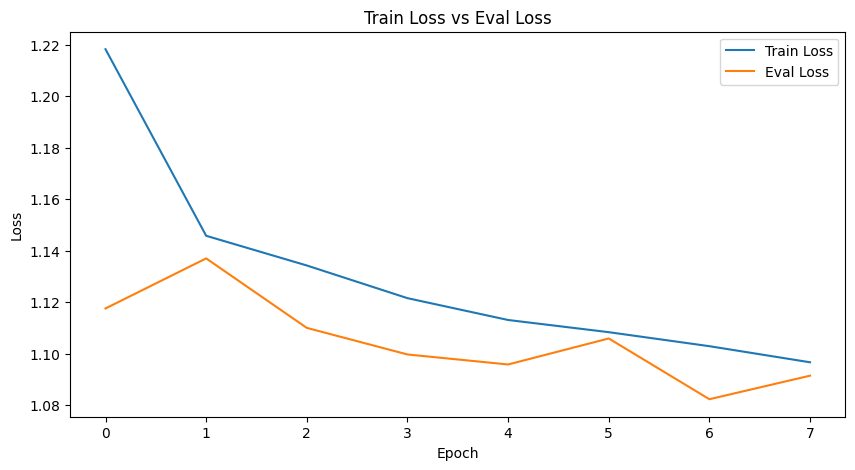

In [10]:
import matplotlib.pyplot as plt

# 绘制训练损失和验证损失的对比图
plt.figure(figsize=(10, 5))
plt.plot(train_loss_record, label='Train Loss')
plt.plot(eval_loss_record, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Eval Loss')
plt.legend()
plt.show()


In [18]:
import torch
from fnet import MaskLoss, Conv3DStack
model = torch.load("C:\\Users\\lucyc\\Desktop\\freckers_data\\P2_Mini.pth", weights_only=False)
model2 = torch.load("C:\\Users\\lucyc\\Desktop\\freckers_data\\P1_Mini.pth", weights_only=False)
#model2 = Conv3DStack()

In [20]:
from mcts import mcts_data_collect, mcts_competition
class MctsConfig:
    def __init__(self) -> None:
        self.c = 1.5
        self.t = 1
        self.finish = False
        self.visulze = False
        self.small = 0.0000001

        self.dirichlet_alpha = 0.03
        self.dirichlet_epsilon = 0.25

#res1 = mcts_competition(model, 1, r"C:\Users\lucyc\Desktop\freckers_data\temp.h5", MctsConfig(), 3, 150, model2)
print(mcts_competition(model2, 1, r"C:\Users\lucyc\Desktop\freckers_data\temp.h5", MctsConfig(), 3, 150, model, visulze=True))
print(mcts_competition(model2, 1, r"C:\Users\lucyc\Desktop\freckers_data\temp.h5", MctsConfig(), 3, 150, model, visulze=False))

线程 1 第 0 轮游戏  第 0 步 模拟进行中

Rounds:  1
🟢🔴🔴🔴🔴🔴🔴🟢
⚪🟢🟢🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🟢🟢🟢🟢⚪
🔵⚪🔵🔵🔵🔵🔵🟢
move action:  (7, 1, 7, 0, False)
线程 1 第 0 轮游戏  第 1 步 模拟进行中

Rounds:  2
🔴🔴⚪🔴🔴🔴🔴🟢
⚪🟢🟢🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🟢🟢🟢🟢⚪
🔵⚪🔵🔵🔵🔵🔵🟢
move action:  (0, 2, 0, 0, False)
线程 1 第 0 轮游戏  第 2 步 模拟进行中

Rounds:  3
🔴🔴⚪🔴🔴🔴🔴🟢
⚪🟢🟢🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🟢⚪
🔵⚪🔵🔵⚪🔵🔵🟢
move action:  (7, 4, 6, 3, False)
线程 1 第 0 轮游戏  第 3 步 模拟进行中

Rounds:  4
🔴⚪⚪🔴🔴🔴🔴🟢
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🟢⚪
🔵⚪🔵🔵⚪🔵🔵🟢
move action:  (0, 1, 1, 2, False)
线程 1 第 0 轮游戏  第 4 步 模拟进行中

Rounds:  5
🔴⚪⚪🔴🔴🔴🔴🟢
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🔵⚪
🔵⚪🔵🔵⚪⚪🔵🟢
move action:  (7, 5, 6, 6, False)
线程 1 第 0 轮游戏  第 5 步 模拟进行中

Rounds:  6
🔴⚪⚪🔴🔴⚪🔴🔴
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🔵⚪
🔵⚪🔵🔵⚪⚪🔵🟢
move action:  (0, 5, 0, 7, False)
线程 1 第 0 轮游戏  第 6 步 模拟进行中

Rounds:  7
🔴⚪⚪🔴🔴⚪🔴🔴
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🔵🟢🔵⚪
🔵⚪🔵⚪⚪⚪🔵🟢
move action:  (7, 3, 6, 4,

KeyboardInterrupt: 

In [ ]:
import threading
import time
from mcts import mcts_data_collect

#(model, thread_num, file, rounds=100, sim_step=300)
# 创建多个线程
threads = []
for i in range(8):
    thread = threading.Thread(target=mcts_data_collect, 
            args=(model, i+1, f"C:\\Users\\lucyc\\Desktop\\freckers_data\\batch_1.h5", 30, 500))
    threads.append(thread)
    thread.start()

# 等待所有线程完成
for thread in threads:
    thread.join()


In [12]:
torch.save(model, "C:\\Users\\lucyc\\Desktop\\freckers_data\\batch_2_no_inverse.pth")

In [9]:
data.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss_rec'])

In [29]:
import numpy as np

In [73]:
import torch

In [74]:
data = torch.load(r"C:\Users\lucyc\Desktop\models\28.pth")
data["loss_rec"]


[1.9039244651794434,
 1.8569676194872176,
 1.8192525863647462,
 1.7976915561235869,
 1.7202053517103195,
 1.6680363416671753,
 1.6309633617815764,
 1.6041356187600355,
 1.5877362736340226,
 1.557925246655941,
 1.533469749821557,
 1.497399920072311,
 1.474102062838418,
 1.4580830521053738,
 1.424927885333697,
 1.4017992183273913,
 1.3770545157519254,
 1.359786742824619,
 1.363577775657177,
 1.3382453041918136,
 1.342527641190423,
 1.3271902203559875,
 1.316656100122552,
 1.3235745277160254,
 1.3114894597958295,
 1.3184155898216443,
 1.292290061712265,
 1.2755796432495117]

In [169]:
import torch
import torch.nn.functional as F

In [204]:
predictions = torch.randn(5, 65, 8, 8)
targets = torch.zeros(5, 65, 8, 8)
random_indices = torch.randperm(5*65*8*8)[:2100]
targets.view(-1)[random_indices] = torch.rand(2100)

In [205]:
# Assuming predictions and targets are already PyTorch tensors
# If not, convert them:
# predictions = torch.from_numpy(predictions)
# targets = torch.from_numpy(targets)

# Split predictions and targets
pred_main = predictions[:, :-1]  # (b, 64, 8, 8)
pred_grow = predictions[:, -1]   # (b, 8, 8)
label_main = targets[:, :-1]
label_grow = targets[:, -1]

# Grow mask operations
grow_mask = label_grow != 0
label_grow = label_grow * grow_mask
pred_grow = pred_grow * grow_mask

# Count non-zero elements and sums
label_grow_counts = torch.count_nonzero(label_grow, dim=(1, 2))
label_grow_sums = torch.sum(label_grow, dim=(1, 2))
pred_grow_counts = torch.count_nonzero(pred_grow, dim=(1, 2))
pred_grow_sums = torch.sum(pred_grow, dim=(1, 2))

# Calculate means with zero division handling
label_grow_mean = torch.zeros_like(label_grow_sums)
mask = label_grow_counts != 0
label_grow_mean[mask] = label_grow_sums[mask] / label_grow_counts[mask]

pred_grow_mean = torch.zeros_like(pred_grow_sums)
mask = pred_grow_counts != 0
pred_grow_mean[mask] = pred_grow_sums[mask] / pred_grow_counts[mask]

# Main mask operations
main_mask = label_main != 0
label_main = label_main * main_mask
pred_main = pred_main * main_mask

In [228]:

B, C, H, W = pred_main.shape
main_mask_flat = main_mask.view(B, -1)
main_mask_flat = torch.concat((main_mask_flat, torch.ones(B, 1, dtype=torch.bool)), dim=1)
pred_main_flat = pred_main.view(B, -1)  # -1 自动计算 H*W
pred_main_flat = torch.concat((pred_main_flat, pred_grow_mean.view(B, 1)), dim=1)
label_main_flat = label_main.view(B, -1)  # -1 自动计算 H*W
label_main_flat = torch.concat((label_main_flat, label_grow_mean.view(B, 1)), dim=1)

loss = 0
count = 0
for i in range(B):
    log_softmax = F.log_softmax(pred_main_flat[i][main_mask_flat[i]])
    labels = label_main_flat[i][main_mask_flat[i]]
    loss += - (labels * log_softmax).sum()  # (B, 8, 8)
    count += len(labels)

loss/count


# pred_main_softmax = torch.stack(pred_softmax)
# labels = torch.stack(labels)

# cross_entropy = - (labels * pred_main_softmax).sum(dim=1)  # (B, 8, 8)





C:\Users\lucyc\AppData\Local\Temp\ipykernel_40920\1087618014.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_softmax = F.log_softmax(pred_main_flat[i][main_mask_flat[i]])


tensor(3.2205)

In [208]:
pred_main_softmax.shape

torch.Size([5, 4097])

In [177]:
label_main_flat.shape


torch.Size([5, 4097])

In [159]:
pred_grow_mean.view(5, 1).shape

torch.Size([5, 1])

In [161]:
pred_main_flat.shape

torch.Size([5, 4096])

In [160]:
torch.concat((pred_main_flat, pred_grow_mean.view(5, 1)), dim=1).shape

torch.Size([5, 4097])

In [102]:
import torch.nn.functional as F

In [93]:
predictions = np.random.randn(5, 65,8,8)
targets = np.zeros((5,65,8,8))
targets = np.zeros((5, 65, 8, 8))
random_indices = np.random.choice(np.arange(5*65*8*8), size=2100, replace=False)
np.put(targets, random_indices, np.random.rand(1))


In [94]:
pred_main = predictions[:, :-1]  # (b, 64, 8, 8)
pred_grow = predictions[:, -1]   # (b, 8, 8)
label_main = targets[:, :-1]
label_grow = targets[:, -1]

In [95]:
grow_mask = label_grow != 0
label_grow = label_grow * grow_mask
pred_grow = pred_grow * grow_mask

label_grow_counts = np.count_nonzero(label_grow, axis=(1, 2))
label_grow_sums = np.sum(label_grow, axis=(1, 2))
pred_grow_counts = np.count_nonzero(pred_grow, axis=(1, 2))
pred_grow_sums = np.sum(pred_grow, axis=(1, 2))

label_grow_mean = np.divide(label_grow_sums, label_grow_counts, out=np.zeros_like(label_grow_sums), where=label_grow_counts!=0)
pred_grow_mean = np.divide(pred_grow_sums, pred_grow_counts, out=np.zeros_like(pred_grow_sums), where=pred_grow_counts!=0)


In [97]:
main_mask = label_main != 0
label_main = label_main * main_mask
pred_main = pred_main * main_mask


In [105]:
label_main

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.99874407, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.99874407],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.99874407, 0.99874407, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.99874407, ..., 0.        ,
          0.        , 0.99874407],
         [0.99874407, 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.99874407, 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0. 